In [25]:
%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [26]:
import tinvest
from datetime import datetime, timedelta
import pandas as pd
import os

def get_candles(
  company,
  interval=tinvest.CandleResolution.min1,
  periods=3,
):
  token = os.environ['TINKOFF_SECRET']
  client = tinvest.SyncClient(
    token,
    use_sandbox=False,
  )

  figi = company["figi"]
  ticker = company["ticker"]
 
  end_date = datetime.now()
  periods_with_candles = 0
  df = pd.DataFrame()
  delta = timedelta(days=1)
  if interval == tinvest.CandleResolution.hour:
      delta = timedelta(weeks=1)
  elif interval in [
      tinvest.CandleResolution.day,
      tinvest.CandleResolution.week,
      tinvest.CandleResolution.month,
  ]:
      delta = timedelta(years=1)

  while periods_with_candles < periods:
      start_date = end_date - delta

      print(
          f"[Tinkoff] Downloading candles for {ticker} {periods_with_candles}/{periods}"  # noqa
      )
      response = client.get_market_candles(
          figi,
          from_=start_date,
          to=end_date,
          interval=interval,
      )

      payload = response.payload

      if len(payload.candles) > 0:
          df = pd.concat(
              [
                  pd.DataFrame(
                      {
                          "Volume": float(c.dict()["v"]),
                          "High": float(c.dict()["h"]),
                          "Low": float(c.dict()["l"]),
                          "Open": float(c.dict()["o"]),
                          "Close": float(c.dict()["c"]),
                          "Date": c.dict()["time"] + timedelta(hours=3),
                      }
                      for c in payload.candles
                  ),
                  df,
              ],
              ignore_index=True,
          )
          periods_with_candles += 1

      end_date = start_date

  df.set_index("Date", inplace=True)

  # remove duplicates
  df = df[~df.index.duplicated(keep="last")]

  print(
      f"[Tinkoff] Candles for {ticker} successfully downloaded!",  # noqa
  )

  return df, figi


periods = 10
interval=tinvest.CandleResolution.min1
companies = [
  # { "figi": 'BBG003PHHZT1', "ticker": "MRNA" },
  { "figi": 'BBG003NJHZT9', "ticker": "DDOG" },
  { "figi": 'BBG0056JW5G6', "ticker": "U" },
  { "figi": 'BBG0022FDRY8', "ticker": "MDB" },
]

def download():
  result = {}
  for company in companies:
    result[company['figi']] = get_candles(company, interval=interval, periods=periods)
  
  return result

result = download()


[Tinkoff] Downloading candles for DDOG 0/10
[Tinkoff] Downloading candles for DDOG 1/10
[Tinkoff] Downloading candles for DDOG 1/10
[Tinkoff] Downloading candles for DDOG 2/10
[Tinkoff] Downloading candles for DDOG 3/10
[Tinkoff] Downloading candles for DDOG 4/10
[Tinkoff] Downloading candles for DDOG 5/10
[Tinkoff] Downloading candles for DDOG 6/10
[Tinkoff] Downloading candles for DDOG 6/10
[Tinkoff] Downloading candles for DDOG 6/10
[Tinkoff] Downloading candles for DDOG 7/10
[Tinkoff] Downloading candles for DDOG 8/10
[Tinkoff] Downloading candles for DDOG 9/10
[Tinkoff] Candles for DDOG successfully downloaded!
[Tinkoff] Downloading candles for U 0/10
[Tinkoff] Downloading candles for U 1/10
[Tinkoff] Downloading candles for U 1/10
[Tinkoff] Downloading candles for U 2/10
[Tinkoff] Downloading candles for U 3/10
[Tinkoff] Downloading candles for U 4/10
[Tinkoff] Downloading candles for U 5/10
[Tinkoff] Downloading candles for U 6/10
[Tinkoff] Downloading candles for U 6/10
[Tinkof

In [27]:
from pandas_ta.overlap import ema, hl2
from pandas_ta.volatility import atr
from pandas import DataFrame
from numpy import NaN as npNaN

def pmax(high, low, close, multiplier=3):
    length = 10

    # Calculate Results
    hl2_ = hl2(high, low)
    mavg = ema(hl2_, length)
    matr = multiplier * atr(high, low, close, length)

    m = close.size
    direction = [1] * m
    trend, long, short = [npNaN] * m, [npNaN] * m, [npNaN] * m

    long_stop = mavg - matr
    short_stop = mavg + matr

    for i in range(1, m):
        long_stop_prev = long_stop.iloc[i - 1]
        long_stop_item = (
            long_stop.iloc[i]
            if mavg.iloc[i] <= long_stop_prev
            else max(long_stop.iloc[i], long_stop_prev)
        )
        long_stop.iloc[i] = long_stop_item

        short_stop_prev = short_stop.iloc[i - 1]
        short_stop_item = (
            short_stop.iloc[i]
            if mavg.iloc[i] >= short_stop_prev
            else min(short_stop.iloc[i], short_stop_prev)
        )
        short_stop.iloc[i] = short_stop_item

        direction_item = direction[i - 1]

        if direction_item == -1 and mavg.iloc[i] > short_stop_prev:
            direction_item = 1
        elif direction_item == 1 and mavg.iloc[i] < long_stop_prev:
            direction_item = -1

        direction[i] = direction_item
        trend[i] = long_stop_item if direction_item == 1 else short_stop_item
        long[i] = long_stop_item if direction_item == 1 else npNaN
        short[i] = short_stop_item if direction_item == -1 else npNaN

    # Prepare DataFrame to return
    # _props = f"_{length}_{multiplier}"
    df = DataFrame(
        {
            f"PMax": trend,
            f"Close": close,
            f"High": high,
            f"Low": low,
            f"PMaxMAvg": mavg,
            f"PMaxLong": long,
            f"PMaxShort": short,
            f"PMaxDirection": direction,
        },
        index=close.index,
    )

    df.name = f"PMax"
    df.category = "overlap"

    return df

In [28]:
# find out previous run ups

import arrow

trades = {}
pmax_multiplier = 3

for company in companies:
    figi = company["figi"]
    ticker = company["ticker"]

    (candles, _) = result[figi]
    pmax_result = pmax(high=candles['High'], low=candles['Low'], close=candles['Close'], multiplier=pmax_multiplier)

    index = 0
    trades[figi] = []

    for (date, pmax_value, mavg, close, high, low) in zip(pmax_result.index, pmax_result['PMax'], pmax_result['PMaxMAvg'], pmax_result['Close'], pmax_result['High'], pmax_result['Low']):
      is_sell = False
      is_buy = False

      if index == 0:
        index += 1
        continue

      if (
          pmax_result['PMax'][index - 1] >= pmax_result['PMaxMAvg'][index - 1]
          and pmax_result['PMax'][index - 2] < pmax_result['PMaxMAvg'][index - 2]
      ):
          is_sell = True
      elif (
          pmax_result['PMax'][index - 1] <= pmax_result['PMaxMAvg'][index - 1]
          and pmax_result['PMax'][index - 2] > pmax_result['PMaxMAvg'][index - 2]
      ):
          is_buy = True

      last_trade = trades[figi][-1] if len(trades[figi]) > 0 else False
      
      if is_sell or is_buy:
        local_date = arrow.get(date)

        if last_trade:
          one_percent = last_trade['price_in'] / 100
          last_trade['price_out'] = close
          last_trade['time_out'] = local_date
          last_trade['profit'] = ((last_trade['price_in'] - last_trade['price_out']) / one_percent) if last_trade['type'] == 'short' else (last_trade['price_out'] - last_trade['price_in']) / one_percent
          last_trade['run_up'] = ((last_trade['price_in'] - last_trade['best_price']) / one_percent) if last_trade['type'] == 'short' else (last_trade['best_price'] - last_trade['price_in']) / one_percent

        trades[figi].append({
          "run_up": 0,
          "profit": 0,
          "time": local_date,
          "type": "short" if is_sell else "long",
          "price_in": close,
          "best_price": close
        })
      else:
        if last_trade:
          if (last_trade["type"] == "short" and low < last_trade["best_price"]) or (last_trade["type"] == "long" and high > last_trade["best_price"]):
            last_trade["best_price"] = low if last_trade["type"] == "short" else high

      index += 1

In [29]:
import math

def round_decimals_down(number:float, decimals:int=1):
    """
    Returns a value rounded down to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor

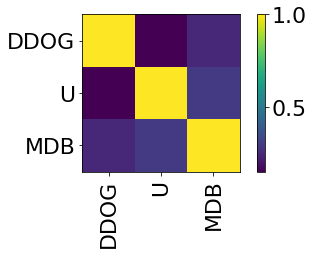

In [30]:
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import plotly.express as px

df = DataFrame()
for company in companies:
    figi = company["figi"]
    ticker = company["ticker"]

    (candles, _) = result[figi]
    df[ticker] = candles['Close']

exp_cov = risk_models.exp_cov(df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plt.show()


In [31]:
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
from functools import reduce

matplotlib.rcParams.update({'font.size': 22})

def frequences(items, ticker):
  more1 = 0
  more04 = 0
  more06 = 0
  more08 = 0

  for item in items:
    if item['run_up'] >= 1:
      more1 += 1
    
    if item['run_up'] >= 0.4:
      more04 += 1

    if item['run_up'] >= 0.6:
      more06 += 1
    
    if item['run_up'] >= 0.8:
      more08 += 1
  
  percent1 = more04 / len(items) * 100
  percent2 = more06 / len(items) * 100
  percent3 = more08 / len(items) * 100
  percent4 = more1 / len(items) * 100

  less04_list = list(filter(lambda x: x['run_up'] < 0.4, items))
  less04_profit = reduce(lambda a, b: a + b['profit'], less04_list, 0)
  
  less06_list = list(filter(lambda x: x['run_up'] < 0.6, items))
  less06_profit = reduce(lambda a, b: a + b['profit'], less06_list, 0)
  
  less08_list = list(filter(lambda x: x['run_up'] < 0.8, items))
  less08_profit = reduce(lambda a, b: a + b['profit'], less08_list, 0)
  
  less1_list = list(filter(lambda x: x['run_up'] < 1, items))
  less1_profit = reduce(lambda a, b: a + b['profit'], less1_list, 0)

  average_less04_profit = round_decimals_down(less04_profit / len(less04_list), 2) if len(less04_list) > 0 else 0
  average_less06_profit = round_decimals_down(less06_profit / len(less06_list), 2) if len(less06_list) > 0 else 0
  average_less08_profit = round_decimals_down(less08_profit / len(less08_list), 2) if len(less08_list) > 0 else 0
  average_less1_profit = round_decimals_down(less1_profit / len(less1_list), 2) if len(less1_list) > 0 else 0

  print(f"""
    ticker: {ticker}
    trades: {len(items)}
    more 0.4% : {round_decimals_down(percent1, 2)}%
    if less than 0.4% then average profit is {average_less04_profit}%. {len(less04_list)} trades
    profit: {round_decimals_down((len(items) - len(less04_list)) * 0.4, 2)}% loss: {round_decimals_down(len(less04_list) * average_less04_profit, 2)}%

    more 0.6% : {round_decimals_down(percent2, 2)}%
    if less than 0.6% then average profit is {average_less06_profit}%. {len(less06_list)} trades
    profit: {round_decimals_down((len(items) - len(less06_list)) * 0.6, 2)}% loss: {round_decimals_down(len(less06_list) * average_less06_profit, 2)}%

    more 0.8% : {round_decimals_down(percent3, 2)}%
    if less than 0.8% then average profit is {average_less08_profit}%. {len(less08_list)} trades
    profit: {round_decimals_down((len(items) - len(less08_list)) * 0.8, 2)}% loss: {round_decimals_down(len(less08_list) * average_less08_profit, 2)}%

    more 1% : {round_decimals_down(percent4, 2)}%
    if less than 1% then average profit is {average_less1_profit}%. {len(less1_list)} trades
    profit: {round_decimals_down((len(items) - len(less1_list)), 2)}% loss: {round_decimals_down(len(less1_list) * average_less1_profit, 2)}%
  """)

print(f"""
periods = {periods}
interval = {interval}
pmax_multiplier = {pmax_multiplier}
""")

def get_stats(items):
  frequences(items, ticker)

  x = list(map(lambda q: q['time'].format('DD/MM HH:mm'), items))

  fig = go.Figure()
  fig.add_trace(
    go.Bar(
      x=x,
      y=list(map(lambda q: q['run_up'], items)),
      name='run up',
      marker_color='green'
    )
  )
  fig.add_trace(
    go.Bar(
      x=x,
      y=list(map(lambda q: q['profit'], items)),
      name='profit',
      marker_color='gray'
    )
  )
  fig.update_layout(
    barmode='group',
  )

  fig.show()

for company in companies:
  figi = company["figi"]
  ticker = company["ticker"]

  filtered = list(filter(lambda x: x['time'].hour >= 17 and x['time'].minute >= 30 and x['time'].hour <= 19, trades[figi]))
  print("Long and Short")
  get_stats(filtered)
  
  # short = list(filter(lambda x: x['type'] == 'short', filtered))
  # print("Short")
  # get_stats(short)
  
  # long = list(filter(lambda x: x['type'] == 'long', filtered))
  # print("Long")
  # get_stats(long)





periods = 10
interval = 1min
pmax_multiplier = 3

Long and Short

    ticker: DDOG
    trades: 15
    more 0.4% : 73.33%
    if less than 0.4% then average profit is -2.09%. 4 trades
    profit: 4.4% loss: -8.36%

    more 0.6% : 66.66%
    if less than 0.6% then average profit is -1.97%. 5 trades
    profit: 6.0% loss: -9.85%

    more 0.8% : 66.66%
    if less than 0.8% then average profit is -1.97%. 5 trades
    profit: 8.0% loss: -9.85%

    more 1% : 60.0%
    if less than 1% then average profit is -1.64%. 6 trades
    profit: 9.0% loss: -9.84%
  


Long and Short

    ticker: U
    trades: 15
    more 0.4% : 93.33%
    if less than 0.4% then average profit is -1.67%. 1 trades
    profit: 5.6% loss: -1.67%

    more 0.6% : 93.33%
    if less than 0.6% then average profit is -1.67%. 1 trades
    profit: 8.4% loss: -1.67%

    more 0.8% : 80.0%
    if less than 0.8% then average profit is -1.87%. 3 trades
    profit: 9.6% loss: -5.61%

    more 1% : 66.66%
    if less than 1% then average profit is -1.44%. 5 trades
    profit: 10.0% loss: -7.2%
  


Long and Short

    ticker: MDB
    trades: 14
    more 0.4% : 92.85%
    if less than 0.4% then average profit is -2.84%. 1 trades
    profit: 5.2% loss: -2.84%

    more 0.6% : 92.85%
    if less than 0.6% then average profit is -2.84%. 1 trades
    profit: 7.8% loss: -2.84%

    more 0.8% : 92.85%
    if less than 0.8% then average profit is -2.84%. 1 trades
    profit: 10.4% loss: -2.84%

    more 1% : 85.71%
    if less than 1% then average profit is -2.62%. 2 trades
    profit: 12.0% loss: -5.24%
  
